In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

(train_ds , test_ds), ds_info = tfds.load('mnist', split =[ 'train','test'], as_supervised =True , with_info = True )

C:\Users\benek\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\benek\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

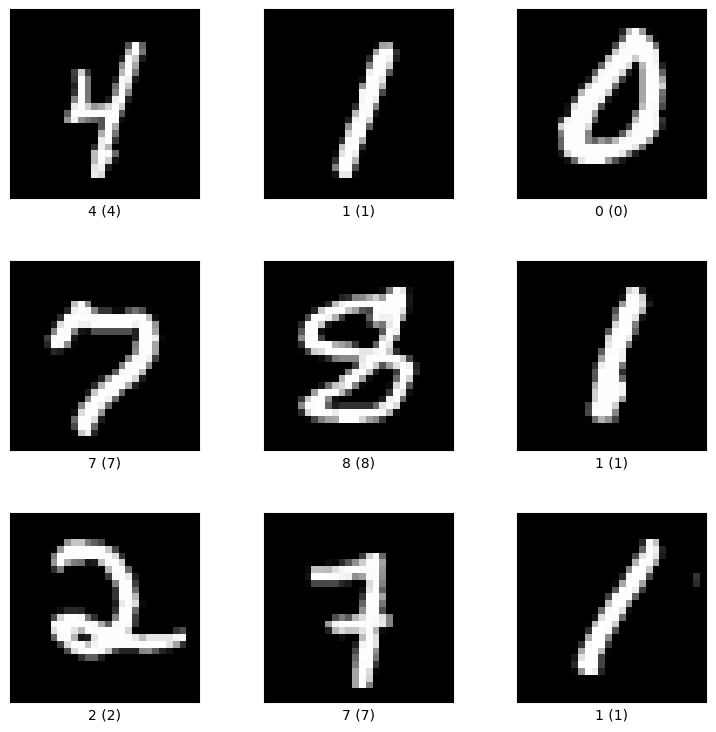

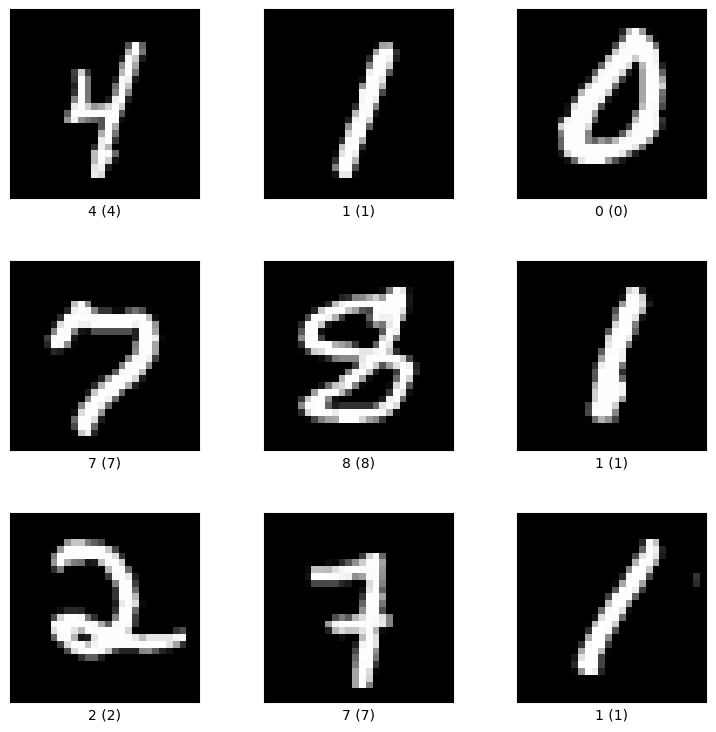

In [3]:
tfds.show_examples(train_ds,ds_info)

In [4]:
def preprocessing(mnist):
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    mnist = mnist.cache()
    mnist = mnist.shuffle(1000)
    mnist = mnist.batch(100)
    mnist = mnist.prefetch(20)
    return mnist
    
train_proc = train_ds.apply(preprocessing)
test_proc = test_ds.apply(preprocessing)

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        #self.hidden1  = tf.keras.layers.Dense(256, activation = 'relu')
        #self.hidden2 = tf.keras.layers.Dense(256, activation = 'relu')
        self.out = tf.keras.layers.Dense(10, activation = 'softmax')

    @tf.function
    def call(self, inputs):
        #x = self.hidden1(inputs)
        #x = self.hidden2(x)
        x = self.out(inputs)
        return x

def training_step (model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def testing (model, test_proc, loss_function):
    accuracy = []
    loss = []
    for (input, target) in test_proc:
        prediction = model(input)
        loss_pred = loss_function(target, prediction)
        accuracy_pred = np.argmax(target, axis=1) == np.argmax(prediction, axis = 1)
        accuracy_pred = np.mean(accuracy_pred)
        loss.append(loss_pred.numpy())
        accuracy.append(np.mean(accuracy_pred))
    
    test_loss = tf.reduce_mean(loss)
    test_accuracy = tf.reduce_mean(accuracy)
    return test_loss, test_accuracy
    
def training (epochs, model, train_proc, test_proc, loss_function, optimizer):
    train_losses = []
    test_losses = []
    test_accuracies = []
    train_loss, _ = testing(model, test_proc, loss_function)
    train_losses.append(train_loss)
    for epoch in range(epochs):
        epoch_loss = []
        for x,y in train_proc:
            train_loss = training_step(model, x, y, loss_function, optimizer)
            epoch_loss.append(train_loss)
            
        train_losses.append (tf.reduce_mean(epoch_loss))
        test_loss, test_accuracy = testing(model, test_proc, loss_function)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f'Accuracy of {np.round(test_accuracies[-1],4)} after epoch number {str(epoch+1)}')

    return train_losses, test_losses, test_accuracies


net = MyModel()
total_train, total_test, total_acc = training(5, net, train_proc, test_proc, tf.keras.losses.CategoricalCrossentropy(), tf.keras.optimizers.SGD(0.01))


Accuracy of 0.8786 after epoch number 1
Accuracy of 0.8979 after epoch number 2
Accuracy of 0.9038 after epoch number 3
Accuracy of 0.9072 after epoch number 4
Accuracy of 0.9106 after epoch number 5


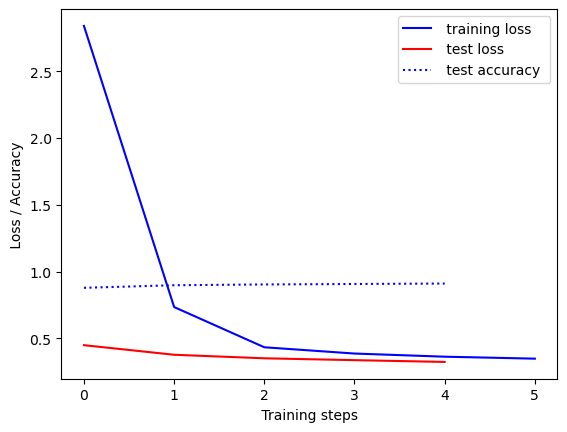

In [5]:
plt.figure()
line1 , = plt. plot( total_train , "b-")
line2 , = plt. plot( total_test , "r-")
line3 , = plt. plot( total_acc , "b:")
plt.xlabel(" Training steps ")
plt.ylabel(" Loss / Accuracy ")
plt.legend(( line1 , line2 , line3 ), (" training loss ", " test loss ", " test accuracy "))
plt.show()